# Surf's Up!: Hawaii Weather Analysis
This project was done using Numpy, Pandas, MatPlotLib, and Seaborn for analysis,
SQLAlchemy serving to connect to a SQLite database I created from CSVs I 
cleaned, and Flask to generate a mini-API.

This README comprises the Weather Analysis portion of the project. For other aspects, please see the following files:
- data_engineering.ipynb : This file contains the code used to clean the provided CSV datasets.
- database_engineering.ipynb : This file contains the code used to create a SQLite database from the cleaned CSVs.
- app.py : This file contains code for a Flask API based on the datasets I used.

Datasets were provided by Trilogy Education Services (&copy; 2017).

In [2]:
# ----------------------------------------------------------------------
# Step 1: Import all necessary modules for analysis
# ----------------------------------------------------------------------
# import modules for analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import aux_func as aux

In [3]:
# ----------------------------------------------------------------------
# Step 2: Set up db connection and session
# ----------------------------------------------------------------------
# set up sqlalchemy engine
from sqlalchemy import create_engine
engine = create_engine('sqlite:///hawaii.sqlite')
conn = engine.connect()

# set up sqlalchemy base
from sqlalchemy.ext.automap import automap_base
Base = automap_base()
Base.prepare(engine, reflect=True)

# map classes
Station = Base.classes.stations
Measurement = Base.classes.measurements

# set up session
from sqlalchemy.orm import Session
session = Session(engine)

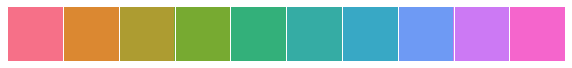

In [4]:
# ----------------------------------------------------------------------
# Step 3: Set overall chart appearances
# ----------------------------------------------------------------------
# set chart style
palette = sns.husl_palette(10)
sns.set(style="darkgrid", palette=palette)

# create dictionary with all color values
hex_codes = palette.as_hex()
palette_dict = {'light coral':hex_codes[0], 
                'orange':hex_codes[1], 
                'goldenrod':hex_codes[2], 
                'olive green':hex_codes[3], 
                'emerald':hex_codes[4], 
                'teal':hex_codes[5], 
                'cerulean':hex_codes[6], 
                'steel blue':hex_codes[7], 
                'lilac':hex_codes[8], 
                'pink':hex_codes[9]}

# show color palette
sns.palplot(palette)

## Precipitation Analysis
Between 8/24/2016 and 8/23/2017, Hawaii appears to have recorded observations of some level of precipitation almost every single day. However, it's unclear if precipitation includes only rain or if it includes precipitation like dew.

Across the 2,015 recorded observations, the maximum amount of precipitation recorded was 6.7 inches, but the mean was 0.18 inches.

In [5]:
# ----------------------------------------------------------------------
# Step 4: Plot 12 months of precipitation data using using DF.plot.
#         Since didn't have data past August 2017, set end date at the 
#         last date where data was available
# ----------------------------------------------------------------------
# create variables for last year's date in string format and query (for readability)
last_year_start = (dt.date(2017,8,23) - dt.timedelta(days=365)).isoformat()
query = f'SELECT date, precipitation FROM measurements WHERE date > "{last_year_start}"'

# read query into dataframe
last_year_prec_df = pd.read_sql(query, engine)

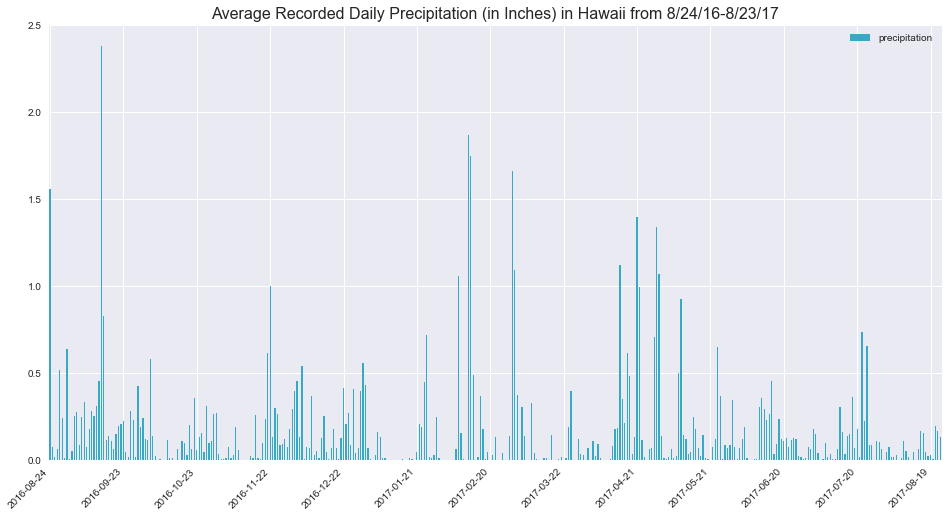

In [6]:
# set style
plt.rcParams["figure.figsize"] = [16,8]

# plot the dataframe
last_year_grouped_df = last_year_prec_df.groupby('date').mean().reset_index()
last_year_grouped_df.plot.bar(color=palette_dict['cerulean'])
plt.title('Average Recorded Daily Precipitation (in Inches) in Hawaii from 8/24/16-8/23/17', 
          size=16)

# set proper labels
plt.xticks([x*30 for x in np.arange(13)],
           [list(last_year_grouped_df['date'])[x*30] for x in np.arange(13)],
           rotation=45, horizontalalignment='right')
plt.show()

In [7]:
# display summary statistics
summary_stats_df = (last_year_prec_df.describe().reset_index().
                    rename(columns={'index':'stat'}).copy())
summary_stats_df['precipitation'] = summary_stats_df['precipitation'].round(2)
summary_stats_df

,stat,precipitation
0,count,2015.00
1,mean,0.18
2,std,0.46
3,min,0.00
4,25%,0.00
5,50%,0.02
6,75%,0.13
7,max,6.70


## Station Analysis
In this section, I parse through the weather stations that were available as part of the dataset.

There are a total of 9 weather stations in Hawaii, according to the dataset. Of those, the station with the highest observation count is USC00519281 WAIHEE 837.5 with a total of 2,772 observation across the dataset.

In [8]:
# ----------------------------------------------------------------------
# Step 6: Calculate the total number of stations
# ----------------------------------------------------------------------
total_stations = pd.read_sql('SELECT COUNT(*) AS "Total Stations" FROM stations', 
                             engine)['Total Stations'][0]
print(f"There are {total_stations} weather stations in Hawaii.")

There are 9 weather stations in Hawaii.


In [9]:
# ----------------------------------------------------------------------
# Step 7: Find the most active stations
# ----------------------------------------------------------------------
# pull the stations and observation counts in descending order
query = 'SELECT m.station, s.name, COUNT(m.temp) AS "Count Observations" \
         FROM measurements m JOIN stations s ON s.station = m.station \
         GROUP BY m.station ORDER BY COUNT(m.temp) DESC'
station_obs_count_desc = pd.read_sql(query,engine)

# display station with highest observation count and df of all stations
highest_obs = f'{station_obs_count_desc["station"][0]} {station_obs_count_desc["name"][0]}'
print(f'The station with the highest observation count is {highest_obs}.')
station_obs_count_desc

The station with the highest observation count is USC00519281 WAIHEE 837.5.


,station,name,Count Observations
0,USC00519281,WAIHEE 837.5,2772
1,USC00513117,KANEOHE 838.1,2696
2,USC00519397,WAIKIKI 717.2,2685
3,USC00519523,WAIMANALO EXPERIMENTAL FARM,2572
4,USC00516128,MANOA LYON ARBO 785.2,2484
5,USC00514830,KUALOA RANCH HEADQUARTERS 886.9,1937
6,USC00511918,HONOLULU OBSERVATORY 702.2,1932
7,USC00517948,PEARL CITY,683
8,USC00518838,UPPER WAHIAWA 874.3,342


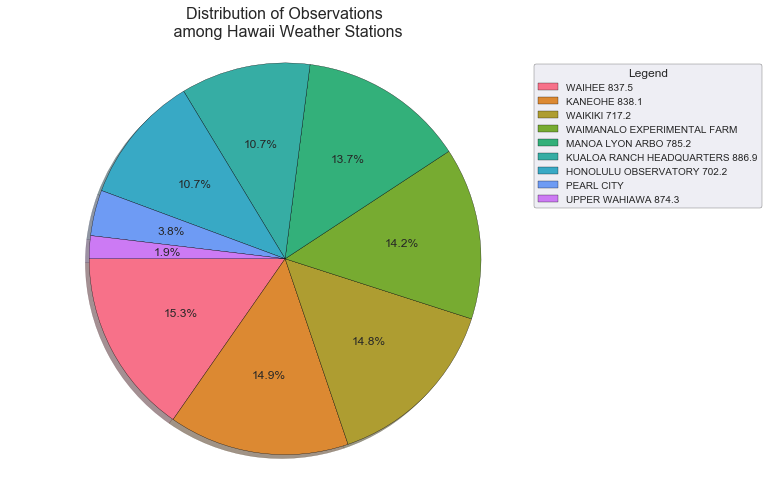

In [10]:
plt.rcParams["figure.figsize"] = [10,8]
plt.pie(station_obs_count_desc['Count Observations'],  
        colors=hex_codes, shadow=True, startangle=180, autopct='%1.1f%%',
        wedgeprops={'edgecolor':'black'})
plt.axis('equal')
plt.title('Distribution of Observations \n among Hawaii Weather Stations',
          size=16)
plt.legend(labels=station_obs_count_desc['name'], bbox_to_anchor=(0.85, 0.85),
           bbox_transform=plt.gcf().transFigure, frameon=True, edgecolor='black',
          title='Legend')
plt.show()

## Temperature Analysis
### Part 1: Temperature Histogram (2016-2017)
Between 8/24/2016 and 8/23/2017, the majority of recorded temperature observations were between 72.5-77.5&deg;F with the average recorded temperature observation somewhere around 75&deg;F.

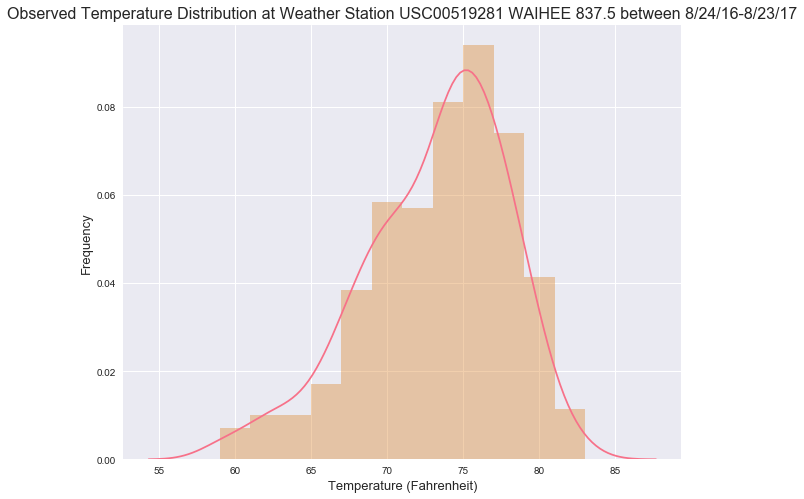

In [11]:
# ----------------------------------------------------------------------
# Step 8: Graph 12 months worth of temperature data from the station with
#       the most observations.
# ----------------------------------------------------------------------
# read query into dataframe
query = f'SELECT date, station, temp FROM measurements \
          WHERE date > "{last_year_start}" AND \
          station = "{station_obs_count_desc["station"][0]}"'
last_year_temp_df = pd.read_sql(query, engine)['temp']

# plot histogram
#plt.hist(x=last_year_temp_df, bins=12, histtype='bar')
sns.distplot(last_year_temp_df, bins=12, color=palette_dict['light coral'],
            hist_kws={'color':palette_dict['orange']})
plt.title(f"Observed Temperature Distribution at Weather Station {highest_obs} between 8/24/16-8/23/17",
         size=16)
plt.xlabel('Temperature (Fahrenheit)', size=13)
plt.ylabel('Frequency', size=13)
plt.show()

### Part Two: Temperature Analysis for Trip to Hawaii
Part of this assignment was to calculate the likely temperature for a theoretical trip to Hawaii for myself. The dates I selected for my trip were: 6/28/2018-07/04/2018.

Results can be seen in the chart below. Barring any unusual weather patterns, I can reasonably expect the average temperature for my trip to be 75&deg;F. As you can see from the error bars, the recorded temperature has reached a minimum of 67&deg;F and a maximum of 82&deg;F, so it seems reasonable to prepare for temperatures to be in the 70s for the majority of my trip.

In [22]:
# ----------------------------------------------------------------------
# Step 9: Calculate the likely average, min, and max for my theoretical 
#         trip
# ----------------------------------------------------------------------# 
# start and end dates for my trip
start_date = dt.date(2018, 6, 28)
end_date = dt.date(2018, 7, 4)

# min and max for data set
min_date = dt.date(2010, 1, 1)
max_date = dt.date(2017, 8, 23)

# set length of previous month
prev_month_length = 30

# get num days and years in data set
num_days = (end_date - start_date).days
num_years = int(round((max_date - min_date).days/365,0))

# create list of all dates to be searched
search_dates = aux.get_search_list(start_date, end_date, min_date, max_date, 
                                prev_month_length, num_days, num_years)

# using list of dates, get avg temp, min temp, max temp in a dataframe
trip_temp_df = aux.calc_temps(num_days, num_years, search_dates, engine)
trip_temp_df = trip_temp_df.sort_values('month/day', ascending=True).reset_index()
trip_temp_df.drop('index', axis=1, inplace=True)
trip_temp_df

,month/day,avg_temp,min_temp,max_temp,avg/min diff,avg/max diff
0,06-28,74.770833,69,80,5.770833,5.229167
1,06-29,74.705882,67,80,7.705882,5.294118
2,06-30,75.380000,67,81,8.380000,5.620000
3,07-01,74.958333,68,81,6.958333,6.041667
4,07-02,75.166667,68,82,7.166667,6.833333
5,07-03,74.808511,68,82,6.808511,7.191489
6,07-04,76.574468,70,81,6.574468,4.425532


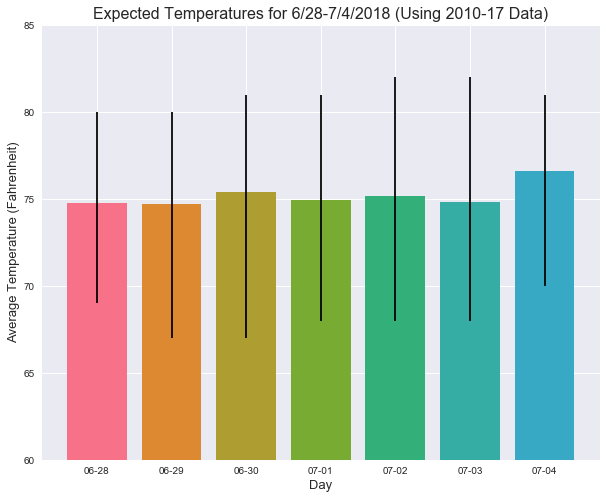

,month/day,avg_temp,min_temp,max_temp,avg/min diff,avg/max diff
0,06-28,74.770833,69,80,5.770833,5.229167
1,06-29,74.705882,67,80,7.705882,5.294118
2,06-30,75.380000,67,81,8.380000,5.620000
3,07-01,74.958333,68,81,6.958333,6.041667
4,07-02,75.166667,68,82,7.166667,6.833333
5,07-03,74.808511,68,82,6.808511,7.191489
6,07-04,76.574468,70,81,6.574468,4.425532


In [31]:
# generate list of error pairs for plotting error bars
yerr_line_list=[]
[yerr_line_list.append((trip_temp_df['avg/min diff'][i] , 
                        trip_temp_df['avg/max diff'][i])) for i in np.arange(num_days+1)]
yerrs = np.array(yerr_line_list).T

# plot error data
plt.bar(x=trip_temp_df['month/day'], 
        height=trip_temp_df['avg_temp'], color=hex_codes)
plt.errorbar(x=trip_temp_df['month/day'],
             y=trip_temp_df['avg_temp'],
             yerr=yerrs,
             ecolor='black', fmt='none')
plt.title("Expected Temperatures for 6/28-7/4/2018 (Using 2010-17 Data)", 
          size=16)
plt.ylabel('Average Temperature (Fahrenheit)', size=13)
plt.xlabel('Day', size=13)
plt.ylim(60,85)
plt.show()
trip_temp_df